In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import copy

In [11]:
# Load data from CSV files
train_data = pd.read_csv('./team13/task2/train_data.csv')
train_label = pd.read_csv('./team13/task2/train_label.csv')
test_data = pd.read_csv('./team13/task2/test_data.csv')
test_label = pd.read_csv('./team13/task2/test_label.csv')

In [18]:
# Convert data to numpy arrays
X_train = train_data.values.astype(np.float32)
y_train = train_label.values.flatten().astype(np.int64)
X_test = test_data.values.astype(np.float32)
y_test = test_label.values.flatten().astype(np.int64)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

In [4]:
class FeedForwardNN(nn.Module):
    def __init__(self, normalization=None):

        super(FeedForwardNN, self).__init__()
        self.normalization = normalization

        # First hidden layer: Linear(36 -> 20)
        self.fc1 = nn.Linear(36, 20)
        if normalization == 'layer':
            self.norm1 = nn.LayerNorm(20)
        elif normalization == 'batch':
            self.bn1 = nn.BatchNorm1d(20)
        self.tanh = nn.Tanh()  # tanh activation

        # Second hidden layer: Linear(20 -> 10)
        self.fc2 = nn.Linear(20, 10)
        if normalization == 'layer':
            self.norm2 = nn.LayerNorm(10)
        elif normalization == 'batch':
            self.bn2 = nn.BatchNorm1d(10)

        # Output layer: Linear(10 -> 5)
        self.fc3 = nn.Linear(10, 5)

    def forward(self, x):
        # First hidden layer
        x = self.fc1(x)
        if self.normalization == 'layer':
            x = self.norm1(x)
        x = self.tanh(x)
        if self.normalization == 'batch':
            x = self.bn1(x)

        # Second hidden layer
        x = self.fc2(x)
        if self.normalization == 'layer':
            x = self.norm2(x)
        x = self.tanh(x)
        if self.normalization == 'batch':
            x = self.bn2(x)

        # Output layer
        x = self.fc3(x)
        return x

In [12]:
def train_and_evaluate(normalization=None):
    # model instance
    torch.manual_seed(42)
    np.random.seed(42)
    model = FeedForwardNN(normalization=normalization)
    # model.load_state_dict(copy.deepcopy(meowmeow[0]))

    # adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    # CE loss
    criterion = nn.CrossEntropyLoss()

    # Separate input into mini batches
    batch_size = max(1, X_train.shape[0] // 10)
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    num_epochs = 10000
    threshold = 4e-5
    loss_history = []
    prev_loss = float('inf')
    patience=0
    model.train()
    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)

        # Early stopping: if improvement is less than the threshold, stop training
        if abs(prev_loss - epoch_loss) < threshold:
            if(patience==0):
              print(f"Early stopping at epoch {epoch+1}")
              break
            patience-=1
        prev_loss = epoch_loss

    return model, loss_history

In [13]:
histories = {}
trained_models = {}

for norm in [None,'layer','batch']:
    norm_label = norm or 'no'
    print(f"\nTraining model with {norm_label} normalization...")
    model, history = train_and_evaluate(norm)
    histories[norm_label] = history
    trained_models[norm_label] = model



Training model with no normalization...
Early stopping at epoch 309

Training model with layer normalization...
Early stopping at epoch 782

Training model with batch normalization...
Early stopping at epoch 184


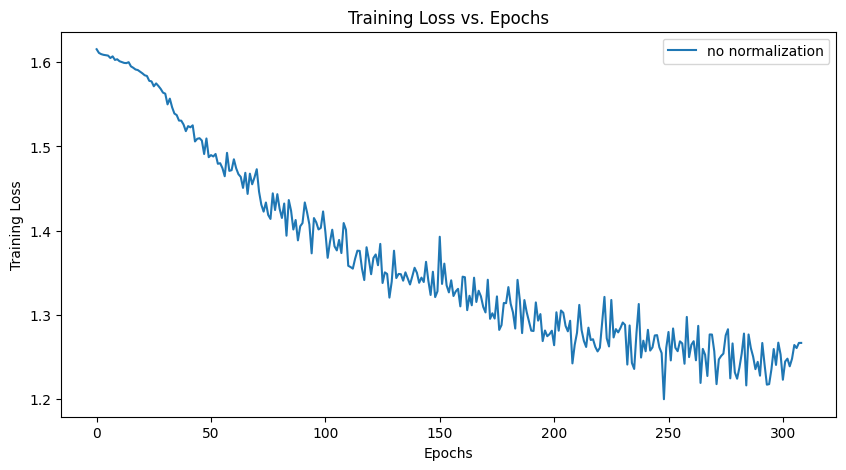

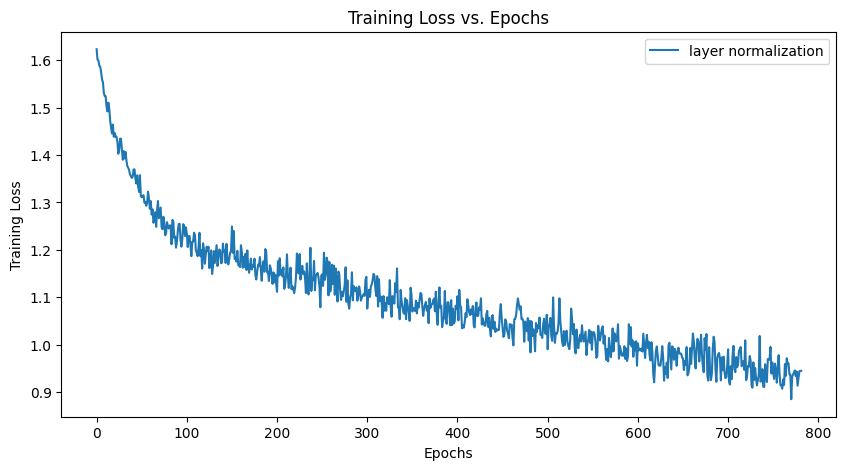

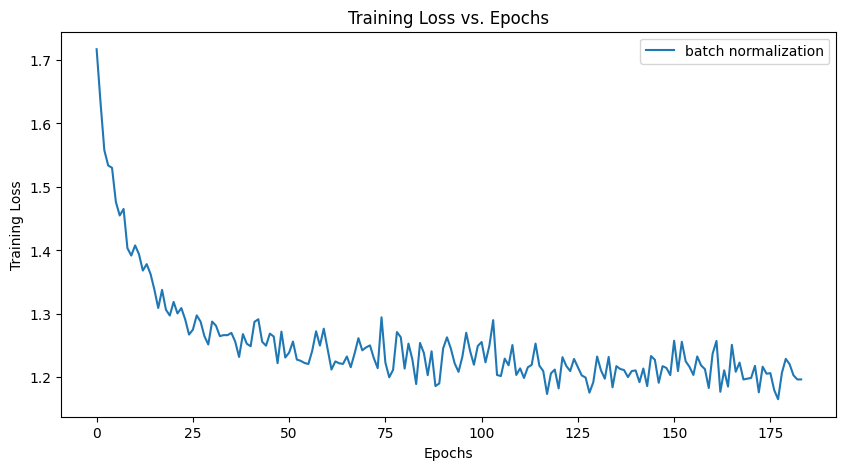

In [14]:
for norm_label, history in histories.items():
    plt.figure(figsize=(10, 5))
    plt.plot(history, label=f'{norm_label} normalization')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs. Epochs')
    plt.legend()
    plt.show()


Confusion Matrix for no normalization (Train Data):


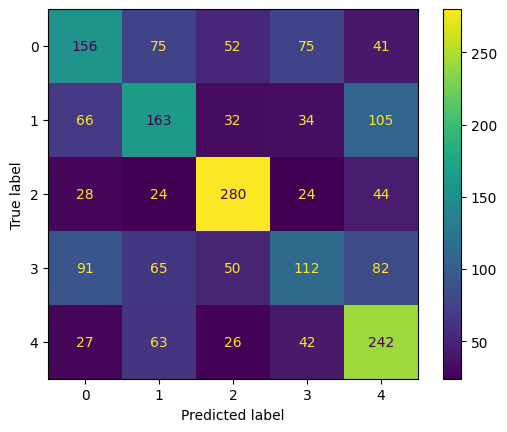

Confusion Matrix for no normalization (Test Data):


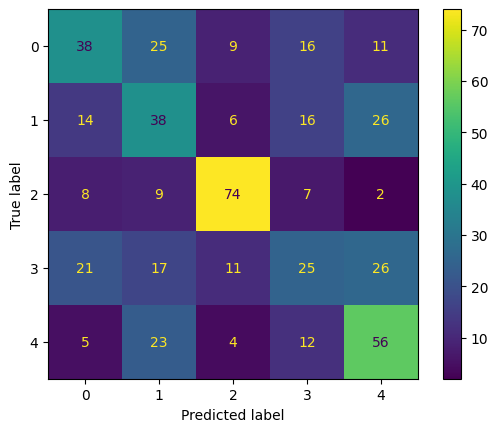


Confusion Matrix for layer normalization (Train Data):


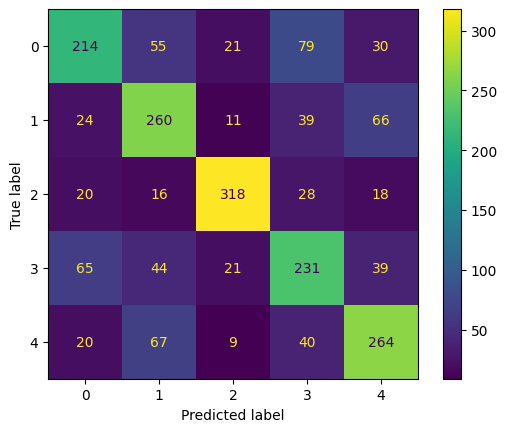

Confusion Matrix for layer normalization (Test Data):


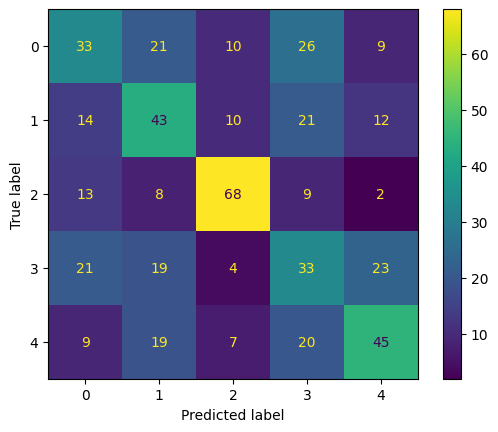


Confusion Matrix for batch normalization (Train Data):


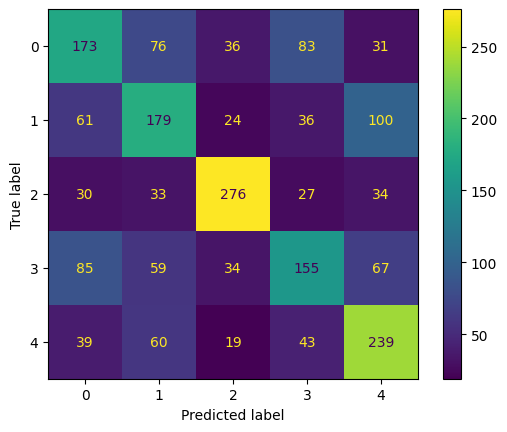

Confusion Matrix for batch normalization (Test Data):


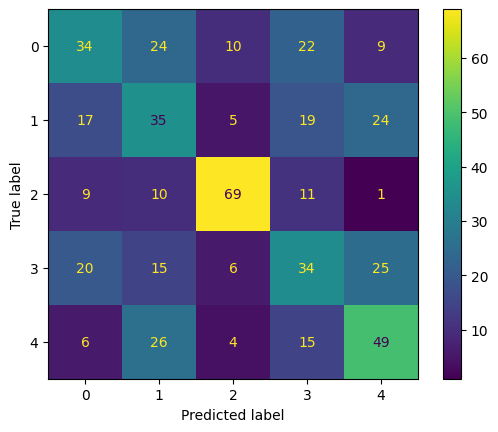

In [15]:
for norm_label, model in trained_models.items():
    model.eval()
    with torch.no_grad():
        # Predictions on training data
        outputs_train = model(X_train)
        _, preds_train = torch.max(outputs_train, dim=1)

        # Predictions on test data
        outputs_test = model(X_test)
        _, preds_test = torch.max(outputs_test, dim=1)
    y_true_train = y_train.numpy()
    y_true_test = y_test.numpy()
    cm_train = confusion_matrix(y_true_train, preds_train.numpy())
    cm_test = confusion_matrix(y_true_test, preds_test.numpy())
    print(f"\nConfusion Matrix for {norm_label} normalization (Train Data):")
    ConfusionMatrixDisplay(cm_train).plot()
    plt.show()

    print(f"Confusion Matrix for {norm_label} normalization (Test Data):")
    ConfusionMatrixDisplay(cm_test).plot()
    plt.show()